<a href="https://colab.research.google.com/github/shayan-mk/Semi-supervisied_CNN_MNIST/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Introduction

# Abstract:

The objective of this project is to demonstrate the effect of semi-supervised image classification over its fully supervised counterpart. Using the MNIST dataset of handwritten digits, the motivation being to show the benefits of having unlabeled data points in the training dataset. Using a convolutional neural network trained over a subset of the labeled MNIST dataset, we leverage its learned associations as an encoder to extract deep features from the remaining subset of the labeled dataset. In the CNN, we use a series of convolutional layers to expose low level features before flattening them for the linear classifier. Applying unsupervised K-means clustering over the unlabeled subset of training data, we introduce a clustering loss factor to these data points in relation to the ground truth label. Using the K-nearest neighbors algorithms, we propagate the set of assignable labels (0-9) over the 10 clusters. The CNN is then trained over the full set of ground-truth and generated-label datapoints. The training set is augmented with crops and rotations, and we introduce Gaussian noise and blurring in the test set. The goal then is to show the varying degrees of effectiveness between fully labeled and different ratios of unlabeled-to-labeled datasets. Especially in the case where the model is able to generalize beyond the data it was trained on (Gaussian transformations). Illustrated and graphed by the change in loss and accuracy at each batch across all epochs for both the training and test MNIST datasets.

# Team members and code contributions:

- Bowen Luo (b23luo@uwaterloo.ca)
    - CNN architecture and loop
    - Dataset loading and splitting
    - Gaussian augmentations
    - Train/evaluation functions
    - Symbolic and batch KNN implementations
    - Plotting

- Shayan Mohammadi Kubijari (s254moha@uwaterloo.ca)
    - Notebook template and formatting
    - Code outline
    - Data augmentation
    - K-means clustering
    - Self-training
    - Extracting deep features
    - Train and test code

# Code outline:

- Apply data augmentation techniques to expand the training/test datasets with rotation, cropping, blurring, and noise transformations.
- Train the initial fully supervised convolutional neural network on the labeled subset of MNIST data.
- Extract deep features from the last layer before the linear classifier for the labeled and unlabeled data points.
- Perform K-means clustering on the deep features to assign cluster labels to the unlabeled data points.
- Use K-Nearest Neighbors (KNN) on the deep features to further refine the labels assigned by K-means clustering based on the labels of their nearest neighbors in the feature space.
- Combine the labeled, K-means labeled, and KNN-refined labeled data points into a single dataset.
- Fine-tune the neural network using this dataset with the combined loss function.

Finally, Evaluate the model performance with varying a variying ratio of labeled data to demonstrate how the performance changes as the ratio gets progressively smaller. We will do this by repeating the above steps for different proportions of the training MNIST dataset.

# Section 1: Code libraries

Aside from essential libraries such as math and numpy, pytorch is used for its tensors, transforms, dataset objects, as well as general CNN related functions including loss functions, convolutional layers, and forward/backward passes over the CNN. Matplotlib is used to graph the loss and accuracies over the batches, sklearn is used for K-means clustering, and we use KeOps for its conversion of tensors into symbolic variables for low overhead matrix operations for K-nearest-neighbors.

Note: running on colab <strong>using GPU</strong>, the following code cell is included for installation of KeOps (pykeops). Locally, it requires the CUDA toolkit and compatible g++ compiler. Further installation requirements can be found here: https://www.kernel-operations.io/keops/python/installation.html

If KeOps is not workable, setting the global variable <strong>USE_SYMBOLIC</strong> below to false will switch to a batched implementation of KNN running on the CPU. This version uses a subset of each K-means cluster as well as a subset of the labeled dataset for efficiency purposes.

In [1]:
!pip install pykeops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.pyplot as plt
from statistics import mode
from sklearn.cluster import KMeans
import copy

# comment out if USE_SYMBOLIC is False
from pykeops.torch import LazyTensor

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [2]:
USE_GPU = True
EPOCH = 2
BATCH = 60
LABELED_RATIO = 0.2
DEVICE = "cpu"
USE_SYMBOLIC = True
CLUSTER_RATIO = 0.05
KNN_LABELED_RATIO = 0.5

In [3]:
def set_device():
    global DEVICE
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Section 2: Define the CNN architecture

In [ ]:
class Net(nn.Module):
    # create convolutional and batch layers 1 through 8 in constructor
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv6_bn = nn.BatchNorm2d(512)
        
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv7_bn = nn.BatchNorm2d(512)
        
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv8_bn = nn.BatchNorm2d(512)
        # create fully connected layers and dropout
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
        self.dropout = nn.Dropout(0.5)

    # define forward pass through network, conversely, could use nn.sequential
    def forward(self, x, extract_features=False):
        x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))), (2, 2))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.conv4_bn(self.conv4(x))), (2, 2))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.max_pool2d(F.relu(self.conv6_bn(self.conv6(x))), (2, 2))
        x = F.relu(self.conv7_bn(self.conv7(x)))
        x = F.max_pool2d(F.relu(self.conv8_bn(self.conv8(x))), (2, 2))
        
        x = torch.flatten(x, 1)

        if extract_features:
            return x

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Section 3: Load, augment, preprocess, and split the dataset
- Augment data with techniques such as random rotations, translations, and flips.
- Preprocess and split the dataset into labeled, unlabeled, and test sets.

In [6]:
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor()
])

crop_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(size=(32, 32)),
    transforms.ToTensor()
])

gaussian_blur_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor()
])

gaussian_noise_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x))
])

In [7]:
def split_dataset(ratio, dataset):
    labeled_size = int(ratio * len(dataset))
    unlabeled_size = len(dataset) - labeled_size
    labeled_augmented_trainset, unlabeled_augmented_trainset = torch.utils.data.random_split(dataset, [labeled_size, unlabeled_size])
    return labeled_augmented_trainset, unlabeled_augmented_trainset

mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transform)
mnist_train_crop = datasets.MNIST(root='./data', train=True, download=False, 
                                transform=crop_augmentation)
mnist_train_blur = datasets.MNIST(root='./data', train=True, download=False, 
                                transform=gaussian_blur_augmentation)
mnist_train_noise = datasets.MNIST(root='./data', train=True, download=False, 
                                transform=gaussian_noise_augmentation)

augmented_trainset = torch.utils.data.ConcatDataset([
    mnist_train, 
    mnist_train_crop])

mnist_test = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transform)
mnist_test_crop = datasets.MNIST(root='./data', train=False, download=False, 
                                transform=crop_augmentation)
mnist_test_blur = datasets.MNIST(root='./data', train=False, download=False, 
                                transform=gaussian_blur_augmentation)
mnist_test_noise = datasets.MNIST(root='./data', train=False, download=False, 
                                transform=gaussian_noise_augmentation)

augmented_testset = torch.utils.data.ConcatDataset([
    mnist_test, 
    mnist_test_crop, 
    mnist_test_blur, 
    mnist_test_noise])

labeled_augmented_trainset, unlabeled_augmented_trainset = split_dataset(LABELED_RATIO, augmented_trainset)
labeled_loader = torch.utils.data.DataLoader(labeled_augmented_trainset, BATCH, shuffle=True)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_augmented_trainset, BATCH, shuffle=True)

labeled_augmented_trainset_2, unlabeled_augmented_trainset_2 = split_dataset(LABELED_RATIO / 2, augmented_trainset)
labeled_loader_2 = torch.utils.data.DataLoader(labeled_augmented_trainset_2, BATCH, shuffle=True)
unlabeled_loader_2 = torch.utils.data.DataLoader(unlabeled_augmented_trainset_2, BATCH, shuffle=True)

labeled_augmented_trainset_3, unlabeled_augmented_trainset_3 = split_dataset(LABELED_RATIO / 4, augmented_trainset)
labeled_loader_3 = torch.utils.data.DataLoader(labeled_augmented_trainset_3, BATCH, shuffle=True)
unlabeled_loader_3 = torch.utils.data.DataLoader(unlabeled_augmented_trainset_3, BATCH, shuffle=True)

fully_labeled_loader = torch.utils.data.DataLoader(augmented_trainset, BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(augmented_testset, 1, shuffle=True)

# Section 6: Define the training and evaluation functions

## Section 6.1: CNN training, evaluation, and feature extraction

In [8]:
def train(model, dataloader, opt, loss_fn):
    model.train()
    correct = 0
    total_loss = 0
    train_loss = []
    train_acc = []

    for batch, (train, label) in enumerate(dataloader):
        train, label = train.to(DEVICE), label.to(DEVICE)
        opt.zero_grad()
        output = model(train)
        loss = loss_fn(output, label)
        loss.backward()
        opt.step()

        _, predicted = torch.max(output, dim=1)
        correct += (predicted == label).float().sum().item()
        total_loss += loss.item()

        # plot loss and accuracy after every 10 batches
        if (batch - 9) % 10 == 0:
            train_loss.append(loss.item())
            train_acc.append(100 * correct / ((batch + 1) * BATCH))

    accuracy = 100 * correct / len(dataloader.dataset)
    average_loss = total_loss / len(dataloader)

    return average_loss, accuracy, train_loss, train_acc

def evaluate(model, dataloader, loss_fn):
    model.eval()
    correct = 0
    total_loss = 0
    test_loss = []
    test_acc = []

    with torch.no_grad():
        for i, (test, label) in enumerate(dataloader):
            test, label = test.to(DEVICE), label.to(DEVICE)
            output = model(test)
            loss = loss_fn(output, label)

            _, predicted = torch.max(output, dim=1)
            correct += (predicted == label).float().sum().item()
            total_loss += loss.item()

            # plot loss and accuracy after every 100 test points
            if ((i - 99) % 100 == 0):
                test_loss.append(loss.item())
                test_acc.append(100 * correct / (i + 1))

    accuracy = 100 * correct / len(dataloader.dataset)
    average_loss = total_loss / len(dataloader)

    return average_loss, accuracy, test_loss, test_acc

# Extract deep features from the given model
def extract_deep_features(model, dataloader):
    model.eval()
    features_list = []
    label_list = []
    with torch.no_grad():
        for train, label in dataloader:
            train = train.to(DEVICE)
            features = model.forward(train, extract_features=True)
            features_list.append(features.cpu())
            label_list.append(label)

    features_tensor = torch.cat(features_list)
    labels_tensor = torch.cat(label_list)
    return features_tensor, labels_tensor

## Section 6.2: Self-training pseudo-labeling

In [9]:
def self_training_labeling(model, unlabeled_loader):
    model.eval()
    pseudo_labels = []

    with torch.no_grad():
        for data, _ in unlabeled_loader:
            data = data.to(DEVICE)
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            pseudo_labels.extend(predicted.cpu().tolist())

    return torch.tensor(pseudo_labels)

## Section 6.3: KNN + kmeans pseudo-labeling

In [10]:
# Perform K-means clustering on the given data
def k_means_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(data)
    return kmeans

# Assign pseudo-labels to the unlabeled data using KNN
def knn_only_labeling(labeled_features, labels, unlabeled_features, k):
    labeled_broadcast = LazyTensor(labeled_features.unsqueeze(0))
    neighbors = LazyTensor(unlabeled_features.unsqueeze(1))

    # [unlabeled_features x labeled_features] squared L2 distances
    L2_dist = ((labeled_broadcast - neighbors) ** 2).sum(-1)
    knn_indices = L2_dist.argKmin(k, dim=1)
    knn_labels = labels[knn_indices]

    pseudo_labels, _ = knn_labels.mode(dim=1)
    return pseudo_labels

def knn_only_batch_labeling(labeled_features, labels, unlabeled_features, k):
    pseudo_labels = torch.empty(0)
    KNN_batch_loader = torch.utils.data.DataLoader(unlabeled_features, BATCH, shuffle=False)
    labeled_broadcast = labeled_features.unsqueeze(0)

    for batch, unlabeled in enumerate(KNN_batch_loader):
        neighbors = unlabeled.unsqueeze(1)

        # [unlabeled_features x labeled_features] squared L2 distances
        L2_dist = torch.sum((labeled_broadcast - neighbors) ** 2, dim=-1)
        _, knn_indices = torch.topk(L2_dist, k, dim=1, largest=False)
        knn_labels = labels[knn_indices]

        batch_labels, _ = knn_labels.mode(dim=1)
        pseudo_labels = torch.cat((pseudo_labels, batch_labels))
    
    return pseudo_labels

def knn_clustering_labeling(labeled_features, labels, unlabeled_features, k=5, n_clusters=10):
    kmeans_model = k_means_clustering(unlabeled_features, n_clusters)
    pseudo_labels = torch.zeros(len(unlabeled_features))

    for cluster_index in range(n_clusters):
        cluster_indices = torch.nonzero(
            torch.from_numpy(kmeans_model.labels_ == cluster_index)).squeeze()
        cluster_features = unlabeled_features[cluster_indices]
        
        if (USE_SYMBOLIC):
            # using entire cluster in KNN
            knn_labels = knn_only_labeling(labeled_features, labels, cluster_features, k=k)
        else:
            # use a subset of the KNN cluster for efficiency on CPU
            subset_cluster_features = cluster_features[:int(CLUSTER_RATIO * len(cluster_features)), :]
            # use a subset of the labeled dataset for efficiency on CPU
            subset_labeled_features = labeled_features[:int(KNN_LABELED_RATIO * len(labeled_features)), :]
            subset_labels = labels[:int(KNN_LABELED_RATIO * len(labels))]
            knn_labels = knn_only_batch_labeling(subset_labeled_features, subset_labels, subset_cluster_features, k=k)

        # Assign the majority label to the entire cluster
        cluster_label, _ = knn_labels.mode()
        pseudo_labels[cluster_indices] = cluster_label.item()

    return pseudo_labels

## Section 6.4: Merge labeled and pseudo-labeled data

In [11]:
# Merge labeled and pseudo-labeled data
def merge_labeled_and_pseudo_labeled_data(labeled_loader, unlabeled_loader, pseudo_labels):
    # Extract the labeled dataset and replace the targets with pseudo-labels
    labeled_dataset = labeled_loader.dataset
    unlabeled_dataset = unlabeled_loader.dataset
    unlabeled_dataset.targets = pseudo_labels.tolist()

    # Combine the labeled and unlabeled datasets and create a new dataloader
    combined_dataset = torch.utils.data.ConcatDataset([labeled_dataset, unlabeled_dataset])
    combined_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=BATCH, shuffle=True)

    return combined_loader

# Section 7: Train, evaluate the model

In [12]:
def train_and_test(train_loader, test_loader, model_name):
    set_device()
    net = Net()
    net.to(DEVICE)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    for epoch in range(EPOCH):
        avg_train_loss, avg_train_acc, train_loss, train_acc = train(net, train_loader, optimizer, loss)
        avg_test_loss, avg_test_acc, test_loss, test_acc = evaluate(net, test_loader, loss)

        print(f"Epoch {epoch + 1}/{EPOCH}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.2f}%")
        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.2f}%")
        print("-" * 30)

    torch.save(net.state_dict(), model_name)
    return net, train_loss, train_acc, test_loss, test_acc

def extract_and_label(knn_net, labeled_loader, unlabeled_loader):
    # Extract deep features from the supervised model on full ratio labeled data
    deep_features_labeled, labels = extract_deep_features(knn_net, labeled_loader)
    deep_features_unlabeled, _ = extract_deep_features(knn_net, unlabeled_loader)
    # Assign pseudo-labels to the clustered data using K-means and KNN 
    knn_pseudo_labels = knn_clustering_labeling(deep_features_labeled, labels, deep_features_unlabeled, k=5, n_clusters=10)
    # Merge labeled and pseudo-labeled data
    return merge_labeled_and_pseudo_labeled_data(labeled_loader, unlabeled_loader, knn_pseudo_labels)


In [ ]:
knn_net, _, _, _, _ = train_and_test(labeled_loader, test_loader, 'encoder.pth')
st_net = copy.deepcopy(knn_net)

print(f"Fully-supervised MNIST training")
_, fs_train_loss, fs_train_acc, fs_test_loss, fs_test_acc = train_and_test(fully_labeled_loader, test_loader, 'fully-supervised.pth')

# Assign pseudo-labels using self-training
st_pseudo_labels = self_training_labeling(st_net, unlabeled_loader)
# Merge labeled and pseudo-labeled data
st_combined_loader = merge_labeled_and_pseudo_labeled_data(labeled_loader, unlabeled_loader, st_pseudo_labels)

print(f"Semi-supervised MNIST training using self-training")
_, st_train_loss, st_train_acc, st_test_loss, st_test_acc = train_and_test(st_combined_loader, test_loader, 'semi-supervised_st.pth')

knn_combined_loader = extract_and_label(knn_net, labeled_loader, unlabeled_loader)
print(f"Semi-supervised MNIST training using KNN + kmeans with full ratio labeled data")
_, ss_train_loss, ss_train_acc, ss_test_loss, ss_test_acc = train_and_test(knn_combined_loader, test_loader, 'semi-supervised_knn.pth')

knn_combined_loader_2 = extract_and_label(knn_net, labeled_loader_2, unlabeled_loader_2)
print(f"Semi-supervised MNIST training using KNN + kmeans with half ratio labeled data")
_, ss_train_loss_2, ss_train_acc_2, ss_test_loss_2, ss_test_acc_2 = train_and_test(knn_combined_loader_2, test_loader, 'semi-supervised_knn_2.pth')

knn_combined_loader_3 = extract_and_label(knn_net, labeled_loader_3, unlabeled_loader_3)
print(f"Semi-supervised MNIST training using KNN + kmeans with quarter ratio labeled data")
_, ss_train_loss_3, ss_train_acc_3, ss_test_loss_3, ss_test_acc_3 = train_and_test(knn_combined_loader_3, test_loader, 'semi-supervised_knn_3.pth')

# Section 8: Comparison of the methods

The first two sections above correspond to the training and test loss and accuracies of each epochs of the CNN intialization over just the labeled dataset. This primes the neural net for use as the encoder.

The next two sections correspond to the fully-supervised training over the entire training dataset.

The next two sections correspond to the semi-supervised training over the self-assigned labels.

The next two sections correspond to the semi-supervised training over the K-means-KNN-augmented training dataset with the full ratio of labeled data

The next two sections correspond to the semi-supervised training over the K-means-KNN-augmented training dataset with a half ratio of labeled data

The last two sections correspond to the semi-supervised training over the K-means-KNN-augmented training dataset with a quarter ratio of labeled data

# Section 9: Visualize the results and save the model

# Fully supervised results

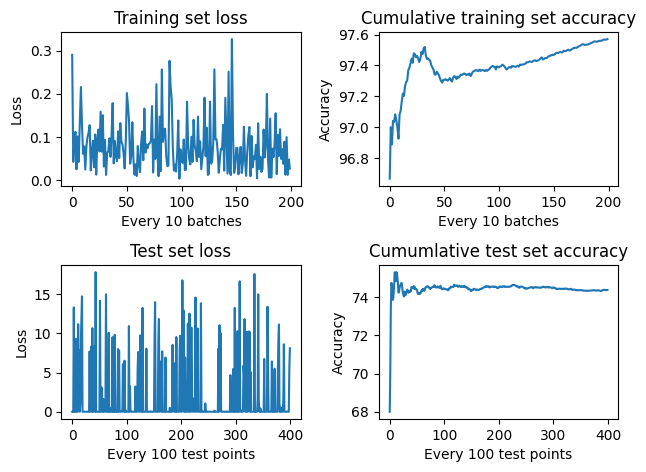

In [14]:
plt.figure(1)

plt.subplot(2, 2, 1)
x_axis = np.arange(len(fs_train_loss))
y_axis = torch.Tensor(fs_train_loss)
plt.title("Training set loss")
plt.xlabel('Every 10 batches')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 2)
x_axis = np.arange(len(fs_train_acc))
y_axis = torch.Tensor(fs_train_acc)
plt.title("Cumulative training set accuracy")
plt.xlabel('Every 10 batches')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 3)
x_axis = np.arange(len(fs_test_loss))
y_axis = torch.Tensor(fs_test_loss)
plt.title("Test set loss")
plt.xlabel('Every 100 test points')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 4)
x_axis = np.arange(len(fs_test_acc))
y_axis = torch.Tensor(fs_test_acc)
plt.title("Cumumlative test set accuracy")
plt.xlabel('Every 100 test points')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.tight_layout(pad=1.0)
plt.show()

# Semi-supervised with Self-training results

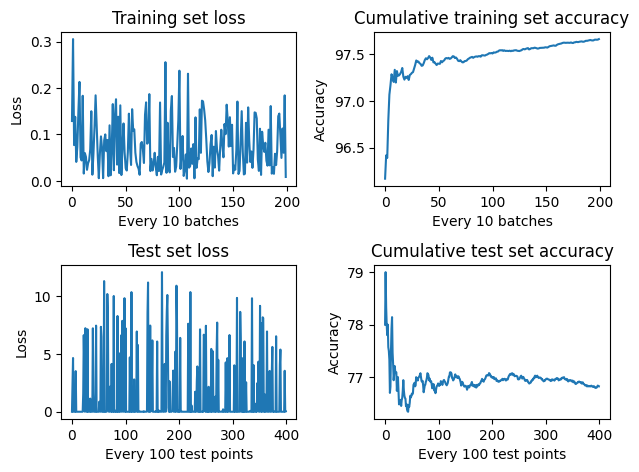

In [15]:
plt.figure(2)

plt.subplot(2, 2, 1)
x_axis = np.arange(len(st_train_loss))
y_axis = torch.Tensor(st_train_loss)
plt.title("Training set loss")
plt.xlabel('Every 10 batches')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 2)
x_axis = np.arange(len(st_train_acc))
y_axis = torch.Tensor(st_train_acc)
plt.title("Cumulative training set accuracy")
plt.xlabel('Every 10 batches')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 3)
x_axis = np.arange(len(st_test_loss))
y_axis = torch.Tensor(st_test_loss)
plt.title("Test set loss")
plt.xlabel('Every 100 test points')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 4)
x_axis = np.arange(len(st_test_acc))
y_axis = torch.Tensor(st_test_acc)
plt.title("Cumulative test set accuracy")
plt.xlabel('Every 100 test points')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.tight_layout(pad=1.0)
plt.show()

# Semi-supervised with KNN + Kmeans results with full ratio labeled data

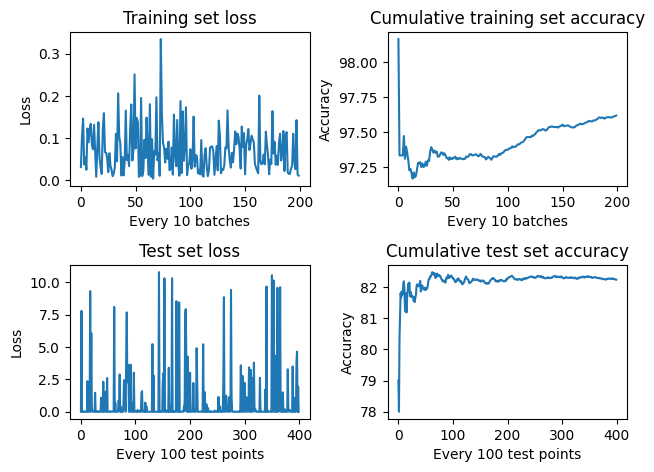

In [16]:
plt.figure(3)

plt.subplot(2, 2, 1)
x_axis = np.arange(len(ss_train_loss))
y_axis = torch.Tensor(ss_train_loss)
plt.title("Training set loss")
plt.xlabel('Every 10 batches')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 2)
x_axis = np.arange(len(ss_train_acc))
y_axis = torch.Tensor(ss_train_acc)
plt.title("Cumulative training set accuracy")
plt.xlabel('Every 10 batches')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 3)
x_axis = np.arange(len(ss_test_loss))
y_axis = torch.Tensor(ss_test_loss)
plt.title("Test set loss")
plt.xlabel('Every 100 test points')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 4)
x_axis = np.arange(len(ss_test_acc))
y_axis = torch.Tensor(ss_test_acc)
plt.title("Cumulative test set accuracy")
plt.xlabel('Every 100 test points')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.tight_layout(pad=1.0)
plt.show()

# Semi-supervised with KNN + Kmeans results with half ratio labeled data

In [ ]:
plt.figure(4)

plt.subplot(2, 2, 1)
x_axis = np.arange(len(ss_train_loss_2))
y_axis = torch.Tensor(ss_train_loss_2)
plt.title("Training set loss")
plt.xlabel('Every 10 batches')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 2)
x_axis = np.arange(len(ss_train_acc_2))
y_axis = torch.Tensor(ss_train_acc_2)
plt.title("Cumulative training set accuracy")
plt.xlabel('Every 10 batches')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 3)
x_axis = np.arange(len(ss_test_loss_2))
y_axis = torch.Tensor(ss_test_loss_2)
plt.title("Test set loss")
plt.xlabel('Every 100 test points')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 4)
x_axis = np.arange(len(ss_test_acc_2))
y_axis = torch.Tensor(ss_test_acc_2)
plt.title("Cumulative test set accuracy")
plt.xlabel('Every 100 test points')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.tight_layout(pad=1.0)
plt.show()

# Semi-supervised with KNN + Kmeans results with quarter ratio labeled data

In [ ]:
plt.figure(5)

plt.subplot(2, 2, 1)
x_axis = np.arange(len(ss_train_loss_3))
y_axis = torch.Tensor(ss_train_loss_3)
plt.title("Training set loss")
plt.xlabel('Every 10 batches')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 2)
x_axis = np.arange(len(ss_train_acc_3))
y_axis = torch.Tensor(ss_train_acc_3)
plt.title("Cumulative training set accuracy")
plt.xlabel('Every 10 batches')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 3)
x_axis = np.arange(len(ss_test_loss_3))
y_axis = torch.Tensor(ss_test_loss_3)
plt.title("Test set loss")
plt.xlabel('Every 100 test points')
plt.ylabel('Loss')
plt.plot(x_axis, y_axis)

plt.subplot(2, 2, 4)
x_axis = np.arange(len(ss_test_acc_3))
y_axis = torch.Tensor(ss_test_acc_3)
plt.title("Cumulative test set accuracy")
plt.xlabel('Every 100 test points')
plt.ylabel('Accuracy')
plt.plot(x_axis, y_axis)

plt.tight_layout(pad=1.0)
plt.show()

# Section 10: Conclusion and final thoughts